# 2. Analyzing the Data

It has monthly data on financial indexes and ETFs from Aug 2011 through May 2025.

## 1.

For the series in the “hedge fund series” tab, report the following summary statistics:

- mean

- volatility

- Sharpe ratio

Annualize these statistics.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%config InlineBackend.figure_format = 'retina'

In [2]:
hedgeFund = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name = "hedge_fund_series")
hedgeFund = hedgeFund.rename(columns = {"Unnamed: 0": "Date"}).set_index("Date")
merrillFactors = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name = "merrill_factors")
merrillFactors = merrillFactors.rename(columns = {"Unnamed: 0": "Date"}).set_index("Date")
hedgeFund.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818


In [3]:
mean, std = hedgeFund.mean() * 12, hedgeFund.std() * np.sqrt(12)
sharpe = mean / std

result = pd.DataFrame({
    "Mean": mean, 
    "Std": std, 
    "Sharpe Ratio": sharpe
})
result.T

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Mean,0.051279,0.038535,0.036526,0.026880,0.028811
Std,0.058796,0.055240,0.055102,0.057388,0.049823
Sharpe Ratio,0.872151,0.697589,0.662880,0.468396,0.578275


---

### 2.

For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.

- Skewness

- Excess Kurtosis (in excess of 3)

- VaR (.05) - the fifth quantile of historic returns

- CVaR (.05) - the mean of the returns at or below the fifth quantile

- Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [4]:
def CalcMaxDrawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [5]:
skew, kurt = hedgeFund.skew(), hedgeFund.kurtosis()
var = hedgeFund.quantile(0.05)
cvar = hedgeFund[hedgeFund <= var].mean()
maxDrawdown = CalcMaxDrawdown(hedgeFund)

result2 = pd.DataFrame({
    "Skew": skew,
    "Kurtosis": kurt,
    "VaR": var,
    "CVaR": cvar,
    "Max Drawdown": maxDrawdown
})
result2.T

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Skew,-0.948272,-0.289982,-0.273477,-0.274904,-0.433508
Kurtosis,5.657351,1.630917,1.589790,1.776481,1.449184
VaR,-0.024008,-0.027002,-0.026970,-0.029919,-0.017171
CVaR,-0.035992,-0.034993,-0.034937,-0.036831,-0.030995
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.140720,-0.137716


---

### 3.

For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

- Market Beta

$$
\tilde{r}_{i, t} = \alpha + \beta * \tilde{r}_{SPY, t} + \epsilon_{t}
$$

- Treynor Ratio: risk-adjusted returns relative to systematic risk

$$
Treynor\ Ratio = \frac{\tilde{\mu}}{\beta}
$$

- Information Ratio: risk-adjusted returns relative to a specific benchmark

$$
Information\ Ratio = \frac{\alpha}{\sigma_{\epsilon}}
$$

Annualize these three statistics as appropriate.

In [6]:
sp500 = merrillFactors["SPY US Equity"]
marketBeta, treynorRatio, infoRatio = list(), list(), list()

# Regression
x = sm.add_constant(sp500)
for col in hedgeFund.columns:
    y = hedgeFund[col].ffill()
    model = sm.OLS(y, x).fit()
    
    alpha, beta = model.params
    epsilon = model.resid.std() * np.sqrt(12)
    
    treynor = y.mean() * 12 / beta
    info = alpha / epsilon

    marketBeta.append(beta)
    treynorRatio.append(treynor)
    infoRatio.append(info)

result3 = pd.DataFrame({
    "Beta":  marketBeta,
    "Treynor Ratio": treynorRatio,
    "Information Ratio": infoRatio
}, index = hedgeFund.columns)
result3.T

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Beta,0.347095,0.342487,0.341483,0.350602,0.301413
Treynor Ratio,0.151364,0.112514,0.106963,0.076669,0.095587
Information Ratio,0.006114,-0.036370,-0.042546,-0.071866,-0.049816


---

### 4.
Discuss the previous statistics, and what they tell us about…

- the differences between SPY and the hedge-fund series?

  - **$\beta^{SPY}$**: Hedge funds have around 30\% ~ 35\% exposure to SPY.

  - **Treynor Ratio**: Hedge funds are generating 3\% ~ 11\% return for each unit of market risk it is exposed to, comparing to 13\% annualized excess return of SPY. This indicate that these hedge funds are underperformed the S&P 500 on a risk-adjusted basis.

  - **Information Ratio**: Hedge funds are generating -0.02 ~ -0.10 information ratio, which reflects their negative $\alpha$. This means these hedge funds cannot generate returns above S&P 500 benchmark.

- which performs better between HDG and QAI.
  - QAI have higher return mean, lower return std, higher Treynor ratio, higher information ratio, and lower exposure to market risk.

- whether HDG and the ML series capture the most notable properties of HFRI.
  - Yes, fitting HFRI by HDG and MLEIFCTR generate 0.81 R-squared. The beta of MLEIFCTR = 0.94 shows a strong positive relationship. Also, 0.0255 tracking error means the replication portfolio tracks the actual HFRI index very closely.

In [7]:
y = hedgeFund["HFRIFWI Index"].ffill()
x = sm.add_constant(hedgeFund[["MLEIFCTR Index", "HDG US Equity"]])

model = sm.OLS(y, x).fit()
print("Weights:")
print(model.params)
print(f"\nR-squared: {round(model.rsquared, 4)}")
print(f"The volatility of tracking error: {round(model.resid.std() * np.sqrt(12), 4)}")

Weights:
const             0.001318
MLEIFCTR Index    0.940123
HDG US Equity     0.018505
dtype: float64

R-squared: 0.8115
The volatility of tracking error: 0.0255


---

### 5.

Report the correlation matrix for these assets.

- Show the correlations as a heat map.

- Which series have the highest and lowest correlations?

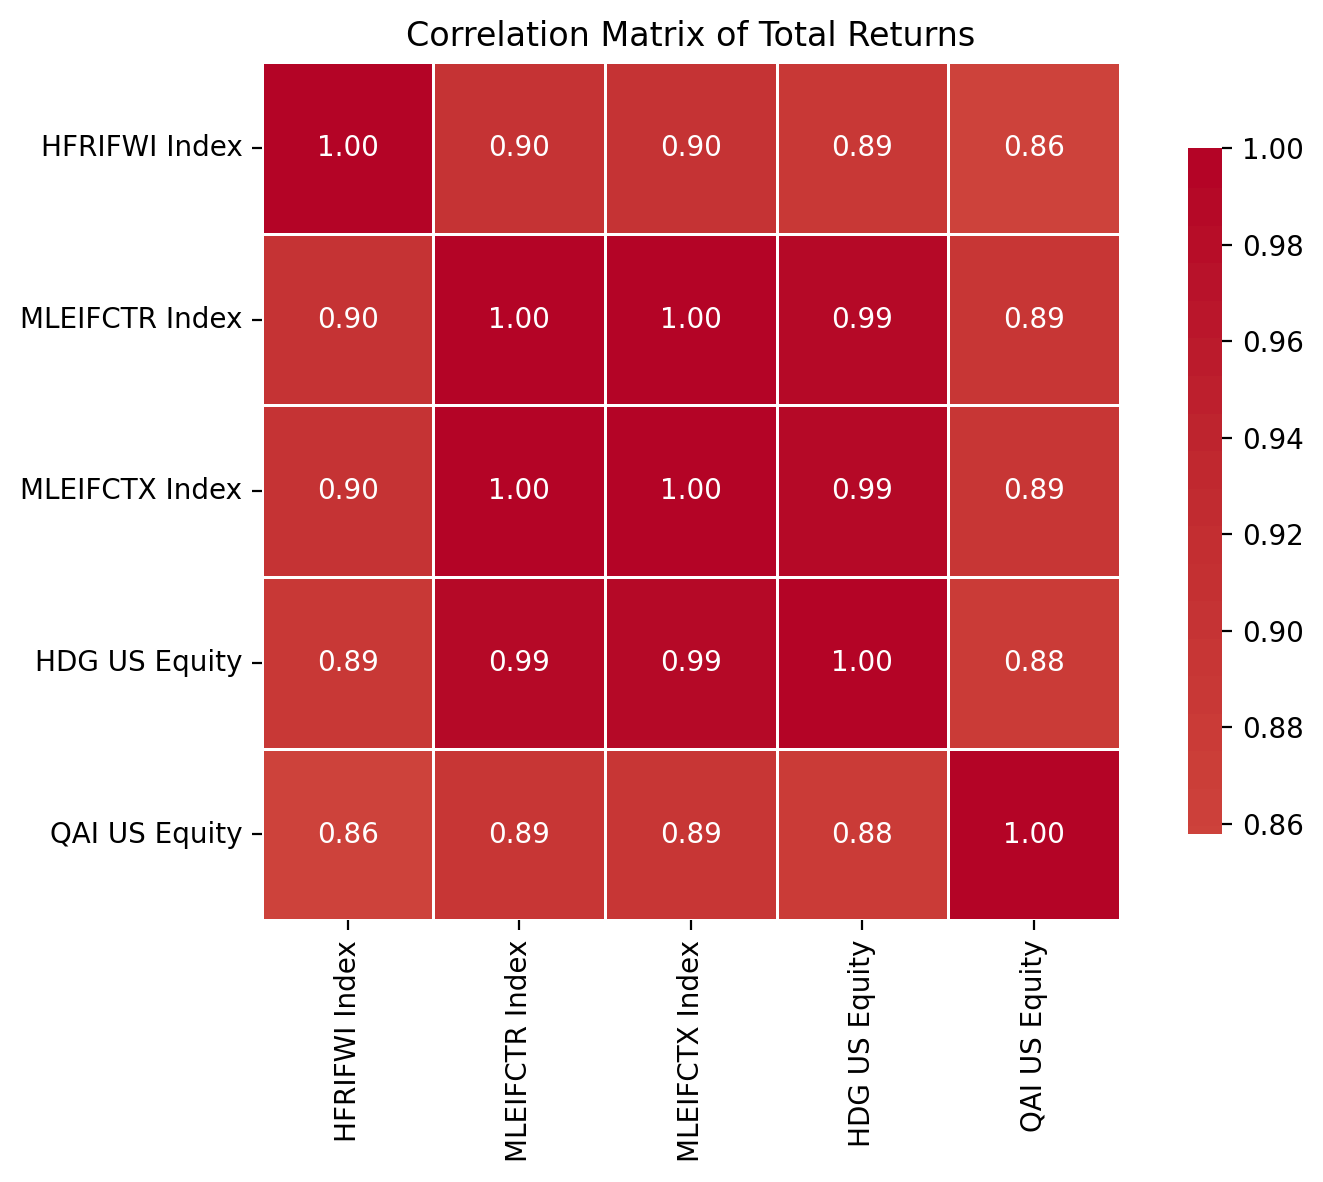

In [8]:
corr_matrix = hedgeFund.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0, 
            square = True, linewidths = 1, cbar_kws = {"shrink": 0.8})
plt.title('Correlation Matrix of Total Returns')
plt.tight_layout()
plt.show()

- They all have very high correlation
  
- ML series has highest correlations to the other assets
  
- QAI has lowest correlations to the other assets

---

### 6.

Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression,

$$
r^{hfri}_t = \alpha^{merr} + x_t^{merr} \beta^{merr} + \epsilon_t^{merr}
$$

$$
\hat r^{hfri}_t = \hat \alpha^{merr} + x_t^{merr} \hat \beta^{merr}
$$

 
Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

- All betas are positive, no short positions required

- Sum of portfolio weights is around $0.73$, which is a long-only portfolio with no leverage

- Do not require huge long-short positions

In [9]:
y = hedgeFund["HFRIFWI Index"].ffill()
x = sm.add_constant(merrillFactors)

model = sm.OLS(y, x).fit()
print(model.params)
print(f"\nSum of portfolio weights: {round(model.params.sum(), 4)}")

const            0.001143
SPY US Equity    0.044539
USGG3M Index     0.353390
EEM US Equity    0.088007
EFA US Equity    0.071560
EUO US Equity    0.030072
IWM US Equity    0.145524
dtype: float64

Sum of portfolio weights: 0.7342


c. Report the R-squared.

d. Report the volatility of $\epsilon^{merr}$, the tracking error.

In [10]:
print(f"R-squared: {round(model.rsquared, 4)}")
print(f"The volatility of tracking error: {round(model.resid.std() * np.sqrt(12), 4)}")

R-squared: 0.843
The volatility of tracking error: 0.0233


---

### 7.

Let’s examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

- Use the previous 60 months of data to estimate the regression equation. This gives time-t estimates of the regression parameters, $\tilde{\alpha_t}^{merr}$ and $\tilde{\beta}^{merr}$.

- Use the estimated regression parameters, along with the time-t regressor values, $x_t^{merr}$, calculate the time-t replication value that is, with respect to the regression estimate, built “out-of-sample” (OOS).

$$
\hat r_t^{hfri} = \tilde{\alpha}^{merr} + (x_t^{merr})^{'}\tilde{\beta}^{merr}
$$

- Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [11]:
t = 60
n = len(hedgeFund["HFRIFWI Index"])
prediction = list()

for i in range(t, n):
    y = hedgeFund["HFRIFWI Index"].ffill().iloc[i-60:i]
    x = sm.add_constant(merrillFactors).iloc[i-60:i]
    model = sm.OLS(y, x).fit()
    
    oosValue = sm.add_constant(merrillFactors).iloc[i:i+1]
    pred = model.predict(oosValue)
    prediction.append(pred.values[0])
    
result4 = pd.DataFrame({
    "Actual Value": hedgeFund["HFRIFWI Index"].iloc[60:],
    "Predict Value": prediction
})
result4

,Actual Value,Predict Value
Date,,
2016-08-31,0.004274,0.004966
2016-09-30,0.006468,0.005001
2016-10-31,-0.005947,-0.004449
2016-11-30,0.007660,0.011650
2016-12-31,0.010063,0.007650
...,...,...
2025-05-31,0.022300,0.018062
2025-06-30,0.023300,0.021267
2025-07-31,0.009700,0.006974


In [12]:
print(f"R-squared: {round(model.rsquared, 4)}")
print(f"The volatility of tracking error: {round(model.resid.std() * np.sqrt(12), 4)}")

R-squared: 0.831
The volatility of tracking error: 0.0238


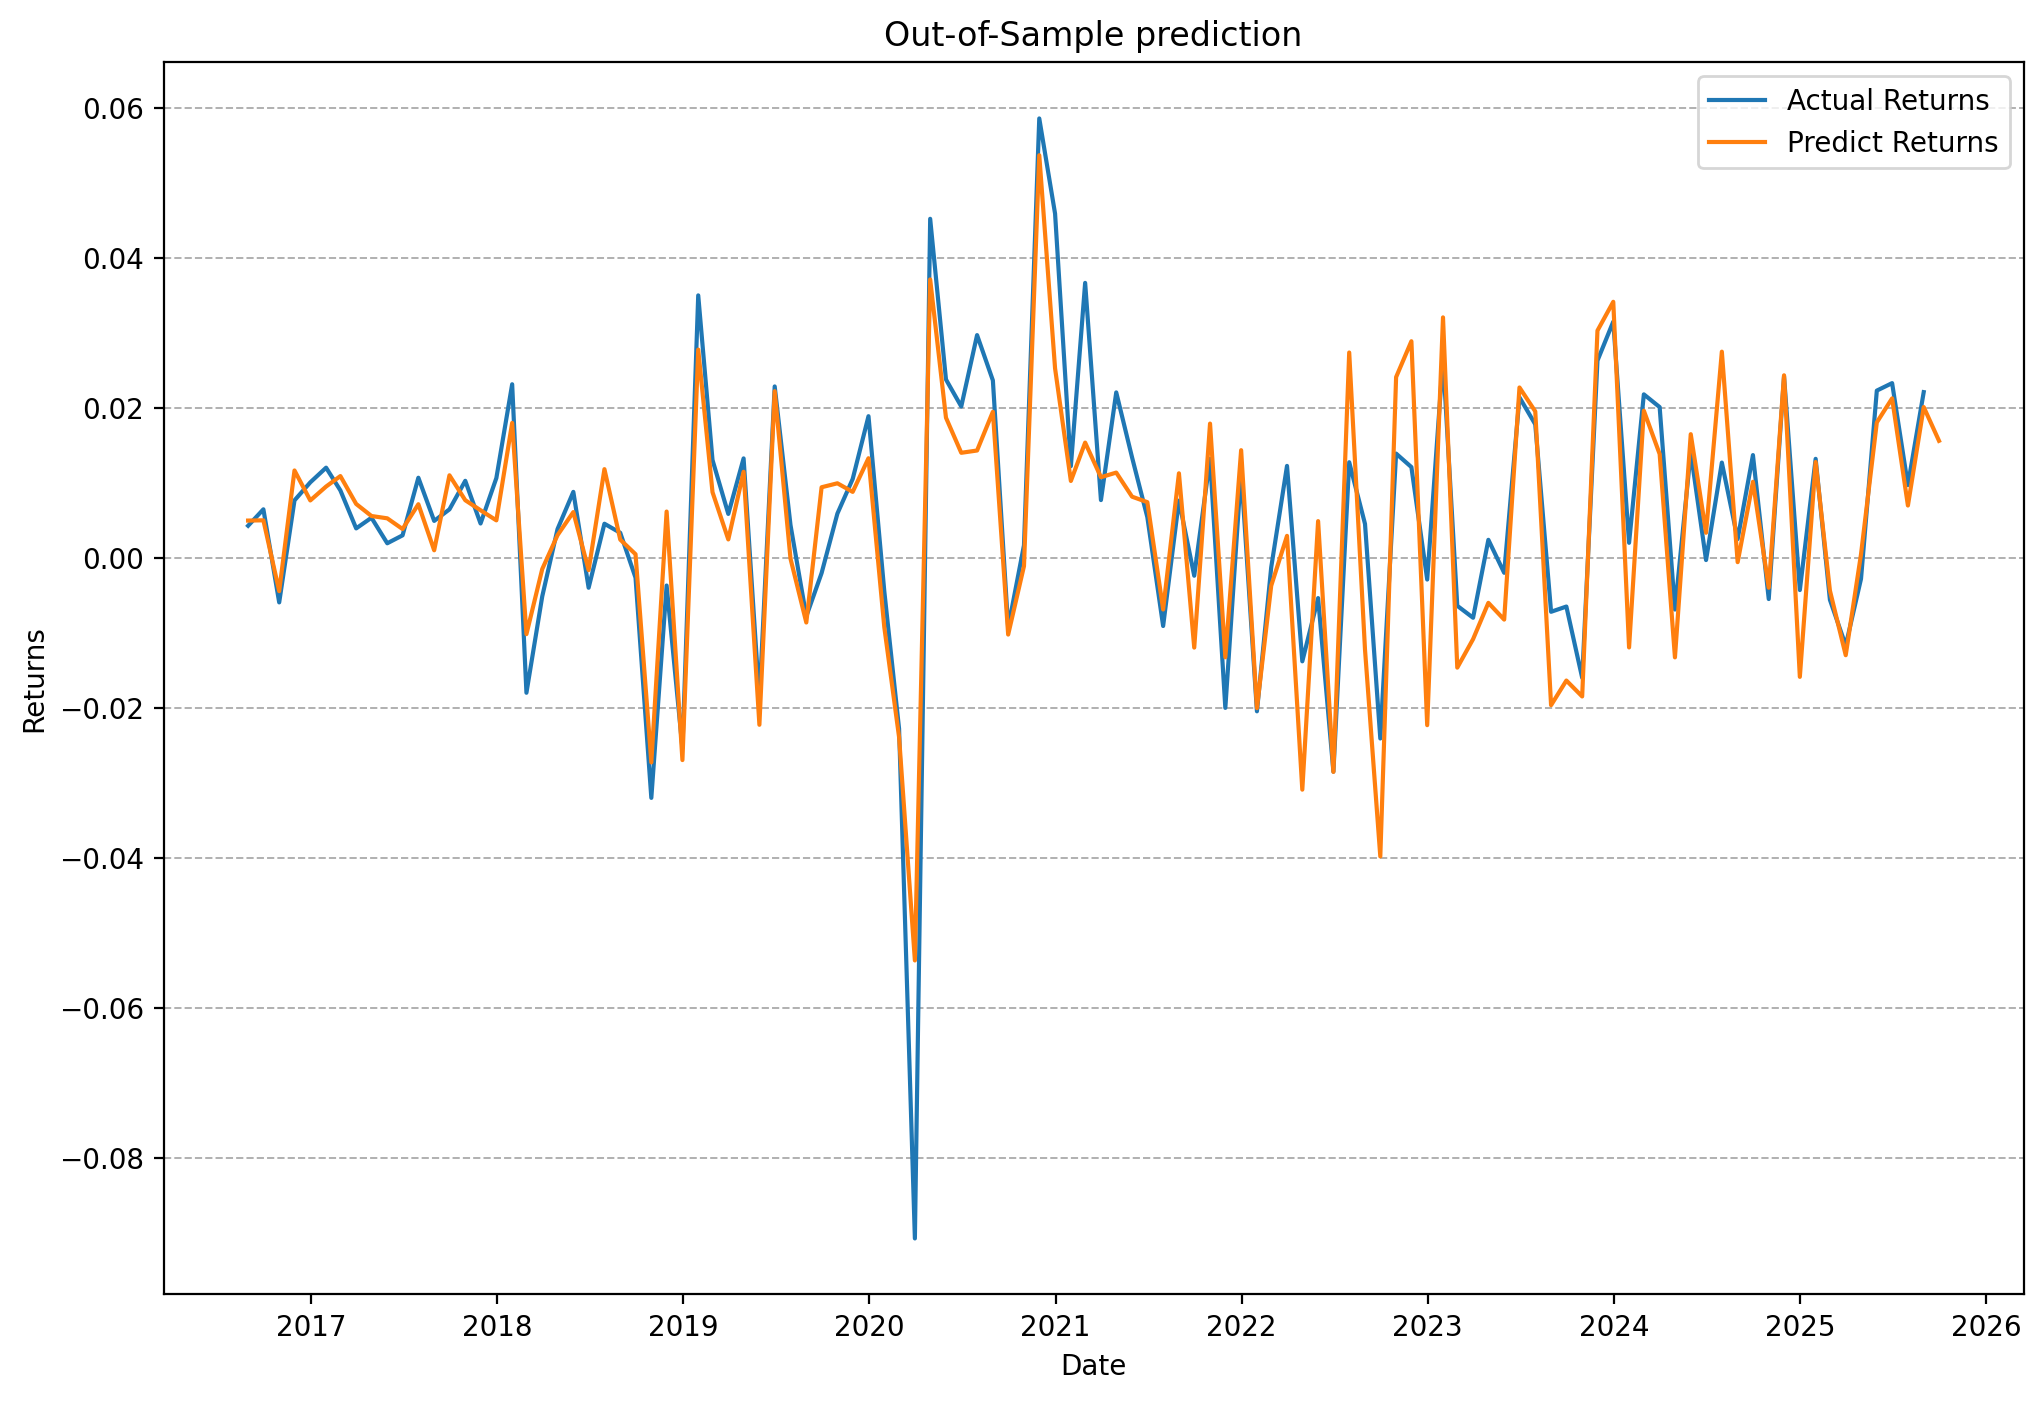

In [13]:
plt.figure(figsize = (12, 8))

plt.plot(result4["Actual Value"], label = "Actual Returns")
plt.plot(result4["Predict Value"], label = "Predict Returns")
plt.title("Out-of-Sample prediction")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.7, axis = 'y')
plt.show()

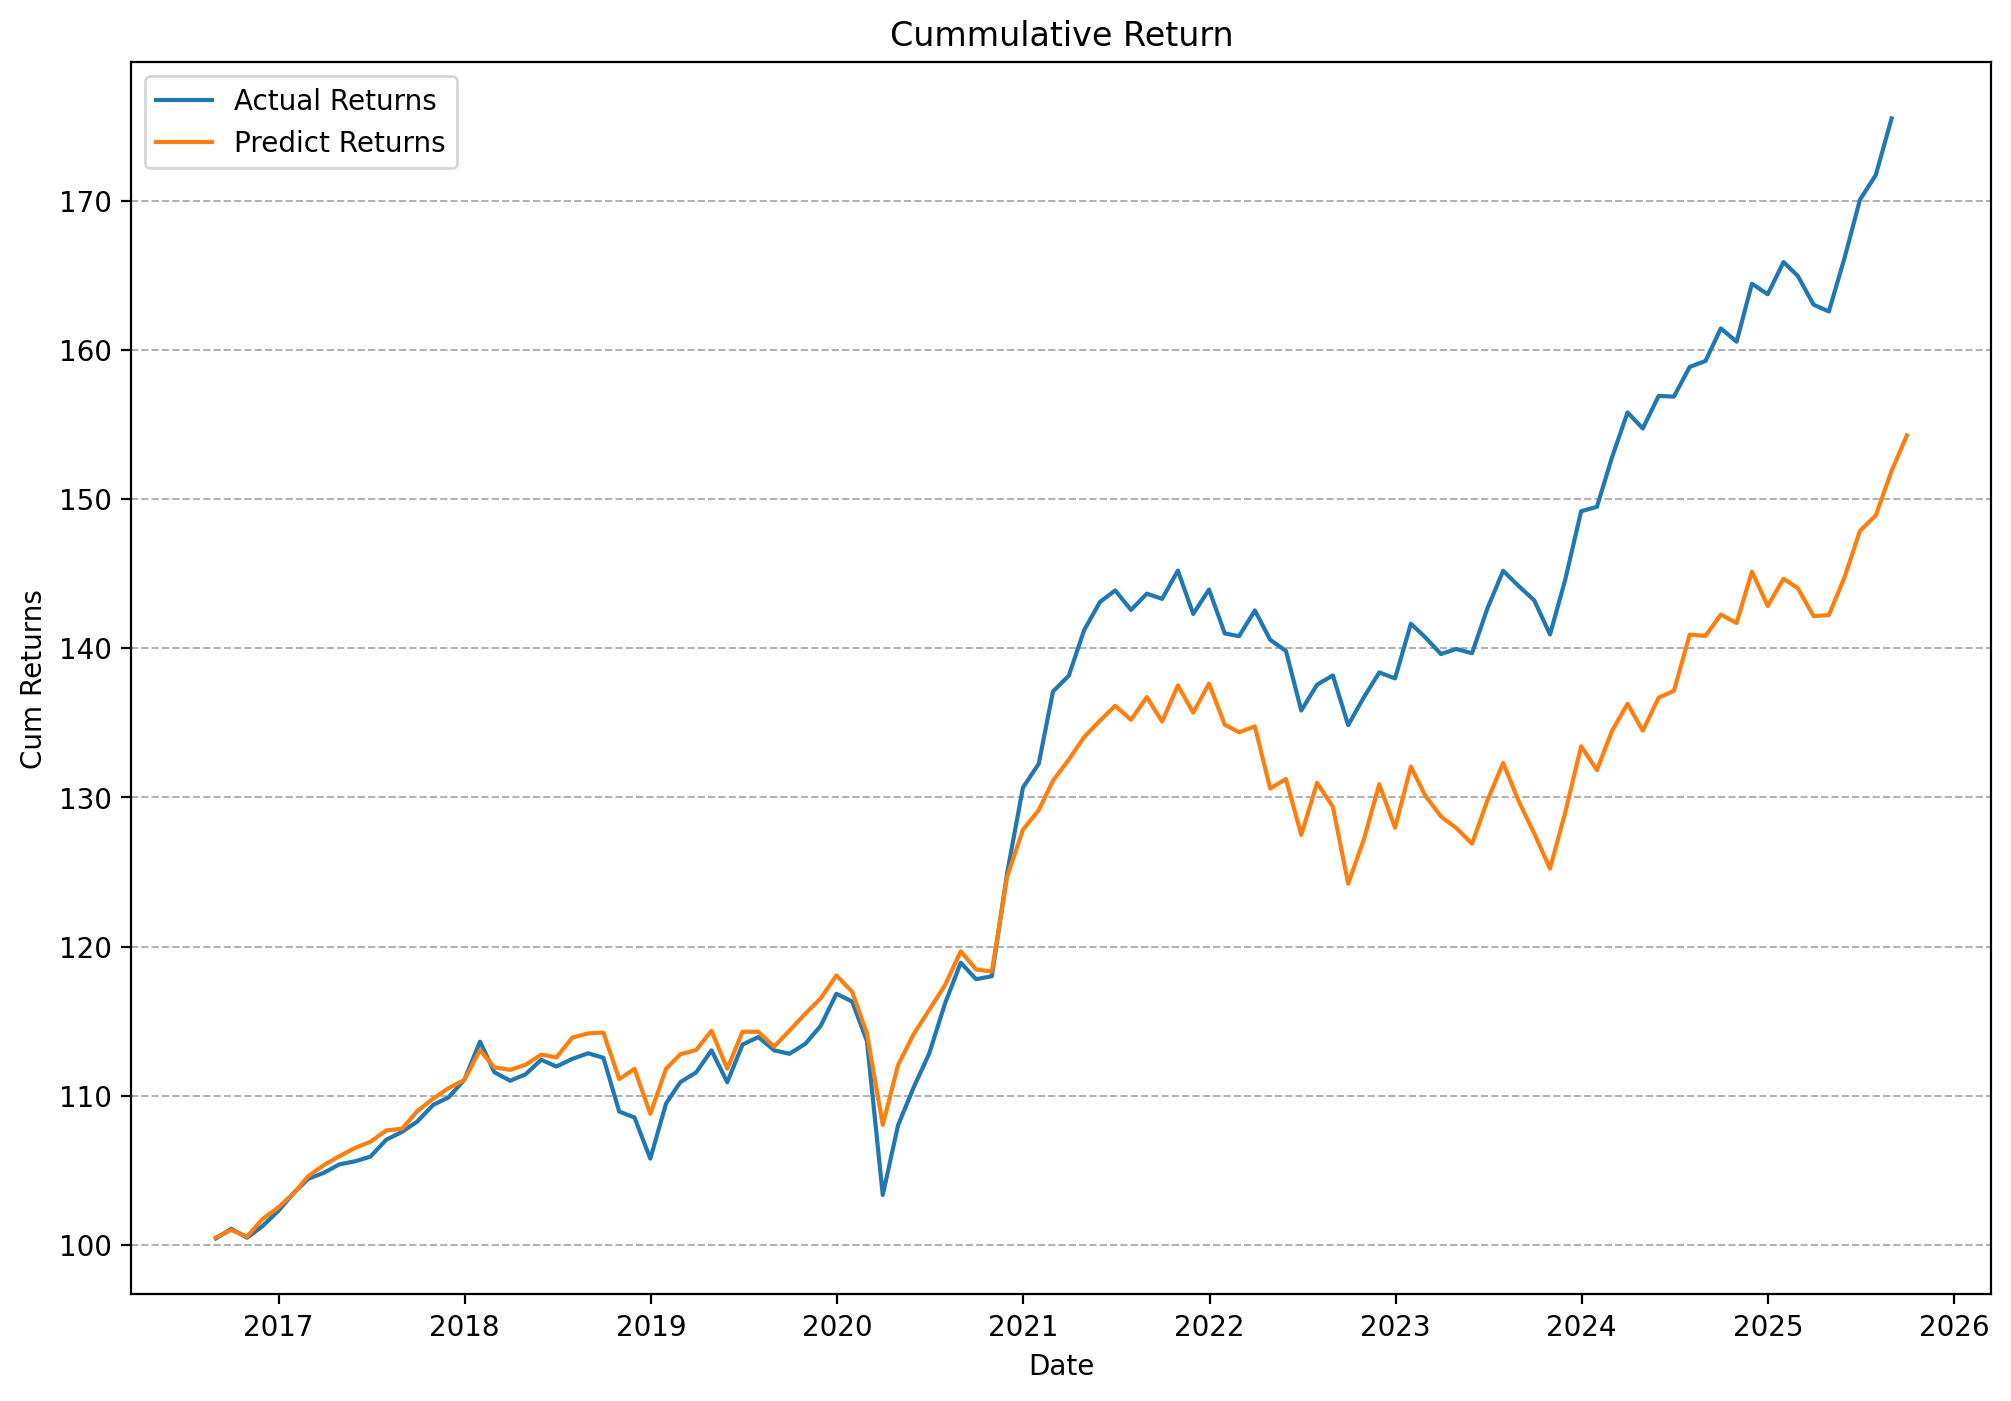

In [14]:
actualCumReturns = 100 * (1 + result4["Actual Value"]).cumprod()
predictCumReturns = 100 * (1 + result4["Predict Value"]).cumprod()

plt.figure(figsize = (12, 8))
plt.plot(actualCumReturns, label = "Actual Returns")
plt.plot(predictCumReturns, label = "Predict Returns")
plt.title("Cummulative Return")
plt.xlabel("Date")
plt.ylabel("Cum Returns")
plt.grid(linestyle = '--', linewidth = 0.7, axis = 'y')
plt.legend()
plt.show()

---

# Exercises - Constrained Optimization

### Data
All the analysis below applies to the data set,

- data/spx_weekly_returns.xlsx

- The file has weekly returns.

- For annualization, use 52 periods per year.

Consider only the following 10 stocks…

As well as the ETF,

<!-- ### Data Processing -->

## 1 Constrained Optimization for Mean-Variance

Continue working with the data above. Suppose we want to constrain the weights such that

- there are no short positions beyond negative 20%, $w_i \geq -0.20$ for all $i$

- none of the positions may have weight over 35%, $w_i \leq 0.35$ for all $i$

- all the asset weights must sum to 1

Furthermore,

- The targeted mean return is 20% per year.

- Be careful; the target is an annualized mean.

Consider using the code below as a starting point.

### 1.1

Report the weights of the constrained portfolio.

Report the mean, volatility, and Sharpe ratio of the resulting portfolio.

In [47]:
data = pd.read_excel("../data/spx_returns_weekly.xlsx", sheet_name = "s&p500 rets").set_index("date")
tickers = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "BRK/B", "AVGO", "LLY"]
df = data[tickers]
df.head()

,AAPL,NVDA,MSFT,AMZN,GOOGL,META,TSLA,BRK/B,AVGO,LLY
date,,,,,,,,,,
2015-01-09,0.024514,-0.009315,0.009195,-0.037534,-0.054445,-0.009055,-0.057685,0.002011,0.047971,-0.001855
2015-01-16,-0.053745,0.000836,-0.020131,-0.020880,0.019448,-0.032931,-0.065760,-0.001739,-0.010268,0.010726
2015-01-23,0.065950,0.037578,0.020329,0.074431,0.061685,0.035255,0.042575,-0.000603,0.030500,0.020514
2015-01-30,0.036997,-0.072636,-0.143706,0.134900,-0.008130,-0.024669,0.011476,-0.034938,-0.038331,-0.001802
2015-02-06,0.019114,0.062269,0.049753,0.055737,-0.006812,-0.018967,0.067589,0.043569,0.018037,-0.022778


In [52]:
targetMean = 0.2
mean = df.mean() * 52
std = df.std() * np.sqrt(52)
cov = df.cov() * 52
n = len(tickers)
initialWeights = np.array([1/n] * n)
bounds = tuple((-0.20, 0.35) for _ in range(n))

In [53]:
def objective(w):        
    return (w.T @ cov @ w)

def objectiveSharpe(w):
    port_mean = mean @ w
    port_std = np.sqrt(w.T @ cov @ w)
    return - (port_mean / port_std)

def ConstraintCapitalFunc(w):
    return np.sum(w) - 1

def ConstraintMeanFunc(w):
    return (mean @ w) - targetMean

constraint_capital = {'type': 'eq', 'fun': ConstraintCapitalFunc} # np.sum(w) = 1
constraint_mean = {'type': 'ineq', 'fun': ConstraintMeanFunc} # np.dot(w, mean) >= 0.2

constraints = ([constraint_capital, constraint_mean])

In [54]:
boundedPortOptimize = minimize(
    objective,
    initialWeights,
    bounds = bounds,
    constraints = constraints
)

boundedOptimalWeights = boundedPortOptimize.x
result5 = pd.DataFrame({
    "Weights": boundedOptimalWeights
}, index = tickers)
result5.T

,AAPL,NVDA,MSFT,AMZN,GOOGL,META,TSLA,BRK/B,AVGO,LLY
Weights,0.080668,-0.059584,0.204361,0.107912,0.046316,0.01126,-0.021293,0.35,0.043621,0.236739


In [55]:
boundedPortfolioMean = boundedOptimalWeights @ mean
boundedPortfolioStd = np.sqrt(boundedOptimalWeights.T @ cov @ boundedOptimalWeights)
boundedPortfolioSharpe = boundedPortfolioMean / boundedPortfolioStd

print(f"Portfolio Mean: {round(boundedPortfolioMean, 4)}")
print(f"Portfolio Std: {round(boundedPortfolioStd, 4)}")
print(f"Portfolio Sharpe Ratio: {round(boundedPortfolioSharpe, 4)}")

Portfolio Mean: 0.2
Portfolio Std: 0.1668
Portfolio Sharpe Ratio: 1.1989


### 1.2.

Compare these weights to the assets’ Sharpe ratios and means.

Do the most extreme positions also have the most extreme Sharpe ratios and means?

Why?

In [56]:
result6 = pd.DataFrame({
    "Mean": mean,
    "STD": std,
    "Sharpe Ratio": mean / std,
    "Weights": boundedOptimalWeights
}, index = tickers)
result6

,Mean,STD,Sharpe Ratio,Weights
AAPL,0.238714,0.276629,0.862938,0.080668
NVDA,0.645580,0.463283,1.393490,-0.059584
MSFT,0.261402,0.239980,1.089266,0.204361
AMZN,0.293447,0.306000,0.958976,0.107912
GOOGL,0.216800,0.279851,0.774698,0.046316
META,0.261924,0.351336,0.745509,0.011260
TSLA,0.469754,0.586431,0.801039,-0.021293
BRK/B,0.135025,0.190654,0.708223,0.350000
AVGO,0.394854,0.375132,1.052574,0.043621
LLY,0.281542,0.282980,0.994919,0.236739


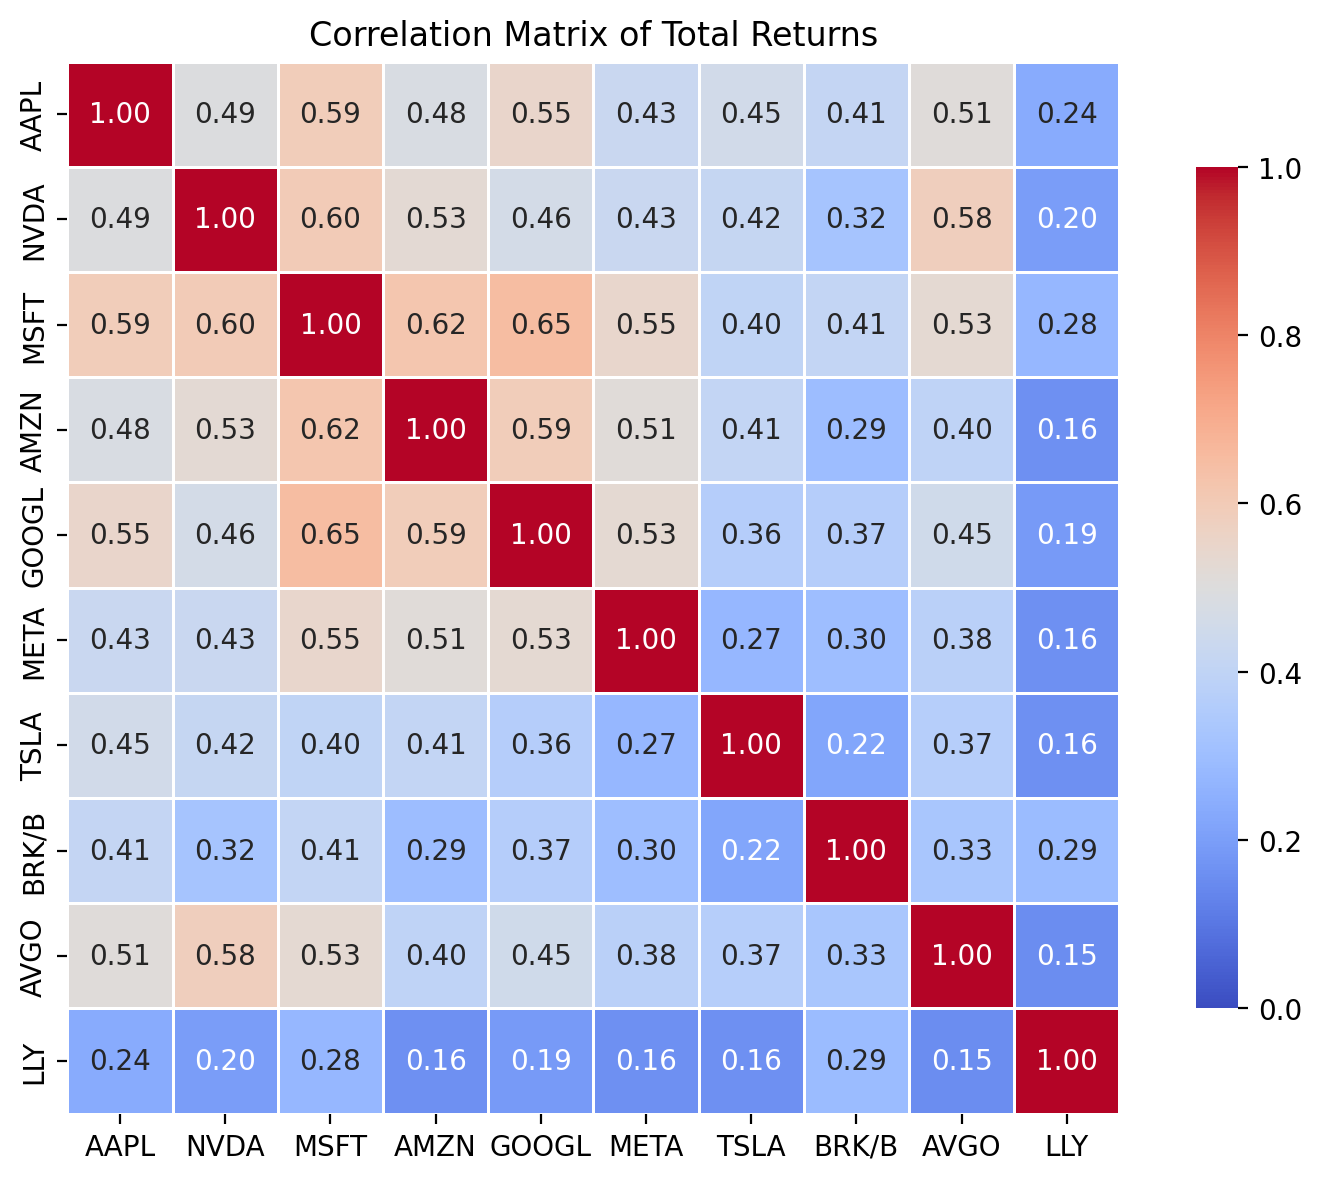

In [57]:
corr_matrix = df.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', vmin = 0, vmax = 1,
            square = True, linewidths = 1, cbar_kws = {"shrink": 0.8})
plt.title('Correlation Matrix of Total Returns')
plt.tight_layout()
plt.show()

Highest weights:
- BRK/B: sharpe = 0.70, weight = 0.35 (capped)

- LLY: sharpe = 0.99, weight = 0.24

Lowest weights:
- NVDA: sharpe = 1.39, weight = -0.06

- TSLA: sharpe = 0.80, weight = -0.02

The goal of optimization is to minimize the overall portfolio variance. Therefore, the optimization will reward those stocks with low correlation (LLY) and low variance (BRK/B), and penalize those stocks with high correlations (NVDA) and high variance (TSLA).

In [58]:
sharpeOptimize = minimize(
    objectiveSharpe,
    initialWeights,
    bounds = bounds,
    constraints = constraints
)

sharpeOptimalWeights = sharpeOptimize.x

result7 = pd.DataFrame({
    "Mean": mean,
    "STD": std,
    "Sharpe Ratio": mean / std,
    "Weights": sharpeOptimalWeights
}, index = tickers)
result7

,Mean,STD,Sharpe Ratio,Weights
AAPL,0.238714,0.276629,0.862938,-0.045714
NVDA,0.645580,0.463283,1.393490,0.315681
MSFT,0.261402,0.239980,1.089266,0.094634
AMZN,0.293447,0.306000,0.958976,0.119234
GOOGL,0.216800,0.279851,0.774698,-0.086912
META,0.261924,0.351336,0.745509,0.006147
TSLA,0.469754,0.586431,0.801039,0.036778
BRK/B,0.135025,0.190654,0.708223,0.087877
AVGO,0.394854,0.375132,1.052574,0.122275
LLY,0.281542,0.282980,0.994919,0.350000


However, if I change the objective function to be sharpe ratio, then the weight of NVDA will increase significantly. On the contrary, the weight of BRK/B also decrease a lot.

### 1.3.
Compare the bounded portfolio weights to the unbounded portfolio weights (obtained from optimizing without the inequality constraints, keeping the equality constraints.)

Report the mean, volatility, and Sharpe ratio of both.

In [59]:
unboundedPortOptimize = minimize(
    objective,
    initialWeights,
    constraints = constraints
)

unboundedOptimalWeights = unboundedPortOptimize.x
result8 = pd.DataFrame({
    "Mean": mean,
    "STD": std,
    "Sharpe Ratio": mean / std,
    "Weights": unboundedOptimalWeights
}, index = tickers)
result8

,Mean,STD,Sharpe Ratio,Weights
AAPL,0.238714,0.276629,0.862938,0.048288
NVDA,0.645580,0.463283,1.393490,-0.030230
MSFT,0.261402,0.239980,1.089266,0.163288
AMZN,0.293447,0.306000,0.958976,0.097997
GOOGL,0.216800,0.279851,0.774698,0.025303
META,0.261924,0.351336,0.745509,0.008190
TSLA,0.469754,0.586431,0.801039,-0.012953
BRK/B,0.135025,0.190654,0.708223,0.452983
AVGO,0.394854,0.375132,1.052574,0.037589
LLY,0.281542,0.282980,0.994919,0.209546


In [60]:
unboundedPortfolioMean = unboundedOptimalWeights @ mean
unboundedPortfolioStd = np.sqrt(unboundedOptimalWeights.T @ cov @ unboundedOptimalWeights)
unboundedPortfolioSharpe = unboundedPortfolioMean / unboundedPortfolioStd

result9 = pd.DataFrame({
    "Portfolio Mean": [boundedPortfolioMean, unboundedPortfolioMean],
    "Portfolio Std": [boundedPortfolioStd, unboundedPortfolioStd],
    "Portfolio Sharpe Ratio": [boundedPortfolioSharpe, unboundedPortfolioSharpe]
}, index = ["Bounded Portfolio", "Unbounded Portfolio"])
result9

,Portfolio Mean,Portfolio Std,Portfolio Sharpe Ratio
Bounded Portfolio,0.2,0.166820,1.198899
Unbounded Portfolio,0.2,0.165349,1.209563


Unbounded Portfolio optimization can reach lower variance and higher sharpe ratio

---

# 3. EXTRA - Other Estimations

### 1.
In Section 2, we estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$
r_t^{hfri} = \alpha^{merr} + x_t^{merr} \beta^{merr} + \epsilon_t^{merr}
$$
$$
\check{r}_t^{hfri} = \check{\alpha}^{merr} + x_t^{merr} \check{\beta}^{merr}
$$

Report

- the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{merr}$?

- the correlations of the fitted values, $\check{r}_t^{hfri}$, to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}_t^{hfri}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [15]:
y = hedgeFund["HFRIFWI Index"].ffill()

model = sm.OLS(y, merrillFactors).fit()
print(model.params)
print(f"\nSum of portfolio weights: {round(model.params.sum(), 4)}")
print(f"R-squared: {round(model.rsquared, 4)}")
print(f"The volatility of tracking error: {round(model.resid.std() * np.sqrt(12), 4)}")

SPY US Equity    0.056239
USGG3M Index     0.676013
EEM US Equity    0.086865
EFA US Equity    0.068162
EUO US Equity    0.031986
IWM US Equity    0.143062
dtype: float64

Sum of portfolio weights: 1.0623
R-squared: 0.8504
The volatility of tracking error: 0.0234


- Sum of portfolio weights > 1, which means we are building the portfolio with leverage

- The weight of USGG3M increase from 0.35 to 0.67, while the others remain almost the same

- The R-squared for a model with no intercept is calculated differently and, therefore, cannot be directly compared to the R-squared of a model that includes an intercept, even if it appears higher

$$
R^2_{standard} = 1 - \frac{\Sigma (y_i - \hat{y}_i)^2}{\Sigma (y_i - \bar{y}_i)^2}
$$

$$
R^2_{no\ intercept} = 1 - \frac{\Sigma (y_i - \hat{y}_i)^2}{\Sigma y_i^2}
$$

- the mean of the fitted value, $\check{r}_t^{hfri}$. How does it compare to the mean of the HFRI?